# Imports

In [70]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

from joblib import Memory, dump, load


In [71]:
# data set returns an empty last column, so dropping it
df = pd.read_csv('https://github.com/YBIFoundation/Dataset/raw/main/Cancer.csv').drop(columns='Unnamed: 32', axis=1)


# EDA

In [72]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [73]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [74]:
df.diagnosis.value_counts()


diagnosis
B    357
M    212
Name: count, dtype: int64

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## df info notes:
- Id column can be dropped
- diagnosis is type object, B for benign M for Malignant; convert to binary
- there is no missing data
- target values are balanced (still, will use stratify option in train_test_split())

## change diagnosis column to binary

In [76]:
lb= LabelBinarizer()
df['diagnosis'] = lb.fit_transform(df['diagnosis'])
# 0 = Benign and 1 = Malignant


In [77]:
df['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

## drop id column

In [78]:
df = df.drop(columns=['id'])
df.head(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


## create X and y

In [79]:
X = df.drop(columns='diagnosis')
X.head(1)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


In [80]:
y = df['diagnosis']
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

## split data

In [81]:
rng = np.random.RandomState(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=rng, stratify=y)

## check multicolinearity

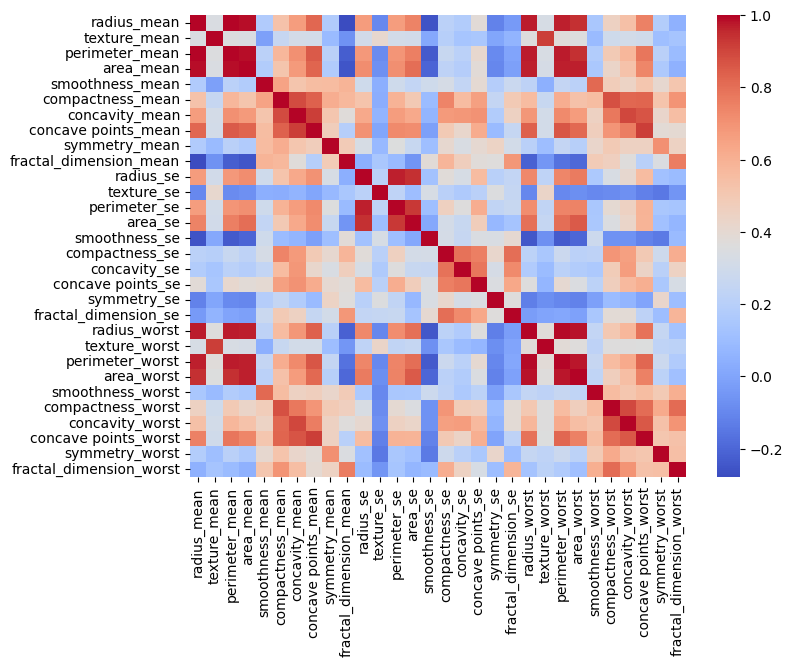

In [82]:
corr_matrix = X_train.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

no HUGE issues with multicolinearity. Will come back to this if model does not perform well or if we need to fine tune

In [83]:
corr_matrix

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.344255,0.997698,0.987621,0.174098,0.526969,0.668781,0.824513,0.171615,-0.278830,0.671508,-0.097981,0.669647,0.748899,-0.255709,0.215125,0.176744,0.382057,-0.118278,-0.037636,0.972145,0.326877,0.967544,0.942924,0.147363,0.450510,0.538301,0.754902,0.181814,0.049139
texture_mean,0.344255,1.000000,0.350841,0.345205,-0.017537,0.257423,0.311473,0.307665,0.087615,-0.066119,0.301106,0.410716,0.309210,0.304161,0.014485,0.198955,0.138027,0.148221,0.002696,0.059088,0.365496,0.918243,0.371785,0.358744,0.087824,0.295525,0.309266,0.297794,0.106691,0.133179
perimeter_mean,0.997698,0.350841,1.000000,0.986617,0.211107,0.578967,0.709475,0.853648,0.207631,-0.226198,0.685101,-0.088414,0.691052,0.759071,-0.236794,0.261378,0.211043,0.414985,-0.093785,0.000068,0.972259,0.332880,0.973334,0.943615,0.177903,0.494078,0.576432,0.782961,0.208041,0.094676
area_mean,0.987621,0.345205,0.986617,1.000000,0.178332,0.520438,0.677611,0.826410,0.172471,-0.250194,0.716158,-0.072637,0.712007,0.804043,-0.206547,0.221818,0.188330,0.381174,-0.099358,-0.017229,0.969696,0.321731,0.965876,0.965903,0.152600,0.431392,0.526618,0.737386,0.164585,0.047553
smoothness_mean,0.174098,-0.017537,0.211107,0.178332,1.000000,0.646079,0.517842,0.553100,0.558125,0.586228,0.294402,0.039475,0.293331,0.243148,0.291174,0.323414,0.240822,0.400261,0.186981,0.271476,0.222890,0.043323,0.247917,0.215001,0.815763,0.479172,0.442126,0.512215,0.407051,0.514328
compactness_mean,0.526969,0.257423,0.578967,0.520438,0.646079,1.000000,0.888042,0.837947,0.611692,0.572546,0.524397,0.033302,0.592463,0.497944,0.091888,0.744137,0.555689,0.656550,0.249403,0.495281,0.556459,0.263044,0.612873,0.530820,0.551408,0.876652,0.822834,0.826365,0.523452,0.697932
concavity_mean,0.668781,0.311473,0.709475,0.677611,0.517842,0.888042,1.000000,0.916539,0.511649,0.372038,0.629820,0.056824,0.668562,0.628450,0.061666,0.679994,0.688276,0.701232,0.178726,0.452426,0.687080,0.308841,0.729529,0.674585,0.454618,0.775593,0.898920,0.867901,0.423657,0.545416
concave points_mean,0.824513,0.307665,0.853648,0.826410,0.553100,0.837947,0.916539,1.000000,0.471316,0.194079,0.704524,0.004721,0.726598,0.715558,-0.016255,0.491123,0.420263,0.620099,0.090441,0.251453,0.836688,0.310058,0.862663,0.815580,0.468896,0.691659,0.762530,0.918493,0.389843,0.398598
symmetry_mean,0.171615,0.087615,0.207631,0.172471,0.558125,0.611692,0.511649,0.471316,1.000000,0.486905,0.328956,0.083571,0.356467,0.261918,0.106326,0.408906,0.338918,0.403413,0.443621,0.309035,0.210720,0.102610,0.245691,0.198283,0.422500,0.492559,0.452857,0.453613,0.708554,0.446101
fractal_dimension_mean,-0.278830,-0.066119,-0.226198,-0.250194,0.586228,0.572546,0.372038,0.194079,0.486905,1.000000,0.040436,0.148474,0.089504,-0.056646,0.380719,0.583158,0.468480,0.379428,0.365992,0.688927,-0.218309,-0.052182,-0.168217,-0.196328,0.487418,0.462560,0.368171,0.204992,0.346720,0.762517


## mutual Info

This test will show how much information each feature shares with the target class (malignant)

In [84]:
X.shape

(569, 30)

In [85]:
mi = mutual_info_classif(X_train, y_train, random_state=rng)
print(X_test.columns, '\n',mi,'\n' )
mi_df = pd.DataFrame(index=X.columns, data=mi, columns=['mi_score'])
mi_df.sort_values(by='mi_score', ascending=False)

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object') 
 [0.35991804 0.10027052 0.40801574 0.3579998  0.10478358 0.23334585
 0.36901461 0.43704654 0.05174101 0.         0.24129446 0.00466313
 0.23507824 0.3546021  0.00713772 0.10069861 0.13922333 0.12336426
 0.0267399  0.06070335 0.44989258 0.13312296 0.48312648 0.46387135
 0.09531976 0.23686175 0.30497467 0.4394231  0.11873979 0.06497652] 



,mi_score
perimeter_worst,0.483126
area_worst,0.463871
radius_worst,0.449893
concave points_worst,0.439423
concave points_mean,0.437047
perimeter_mean,0.408016
concavity_mean,0.369015
radius_mean,0.359918
area_mean,0.358000
area_se,0.354602


# Experiment 1

## model training
This model fit section contains a *logistic regression* model and a *gradient boosting tree* at both default settings. Purpose:
- quick training
- get sense of model / predictions
- we will tune hyperparameters accordingly in experiment 2

In [86]:
#logisitic regression pipe
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=rng))
])

#gradient boosting pipe
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=rng))
])

#fitting pipes
pipe_lr.fit(X_train, y_train)
pipe_gb.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gb',
                 GradientBoostingClassifier(random_state=RandomState(MT19937) at 0x2540DBA3E40))])

## predictions


classification report for logistic regression and for gradient boosting

In [87]:
y_pred_lr = pipe_lr.predict(X_test)
y_pred_proba_lr = pipe_lr.predict_proba(X_test)
y_pred_gb = pipe_gb.predict(X_test)
y_pred_proba_gb = pipe_gb.predict_proba(X_test)
print(f'Logistic Regression classification report:\n{classification_report(y_test, y_pred_lr)}')
print(f'Gradient Boosting classification report:\n{classification_report(y_test, y_pred_gb)}')

Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Gradient Boosting classification report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



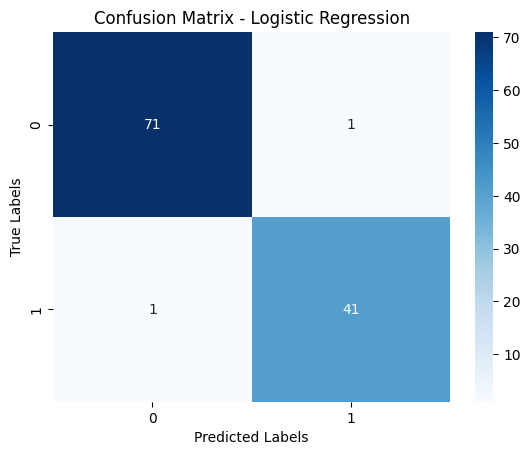

In [88]:
# log reg confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='d')  # fmt='d' for integers
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

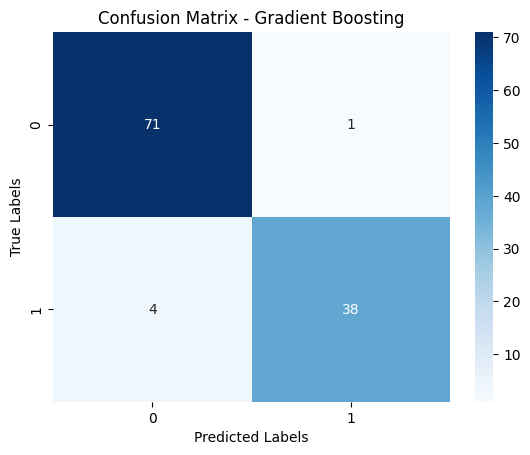

In [89]:
# gradient boosting confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, cmap='Blues', fmt='d')  # fmt='d' for integers
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## auc-roc score

In [90]:
# log reg auc-roc score
auc_roc_lr = roc_auc_score(y_test, y_pred_proba_lr[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr[:, 1])
print(f'Logistic Regression AUC ROC Score: {auc_roc_lr}')

# gradient boosting auc-roc score
auc_roc_gb = roc_auc_score(y_test, y_pred_proba_gb[:, 1])
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_proba_gb[:, 1])
print(f'Gradient Boosting AUC ROC Score: {auc_roc_gb}')

Logistic Regression AUC ROC Score: 0.998015873015873
Gradient Boosting AUC ROC Score: 0.9937169312169312


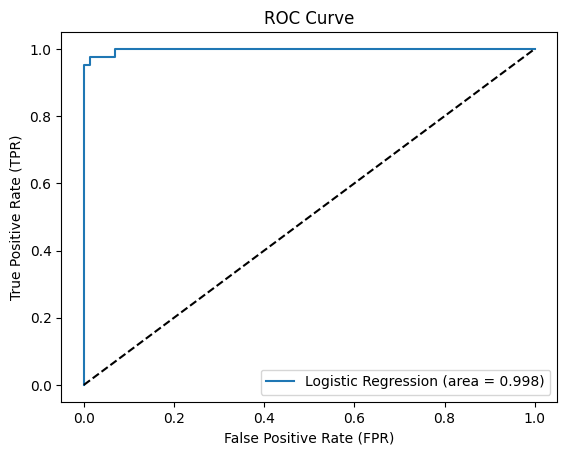

In [91]:
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (area = {auc_roc_lr:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

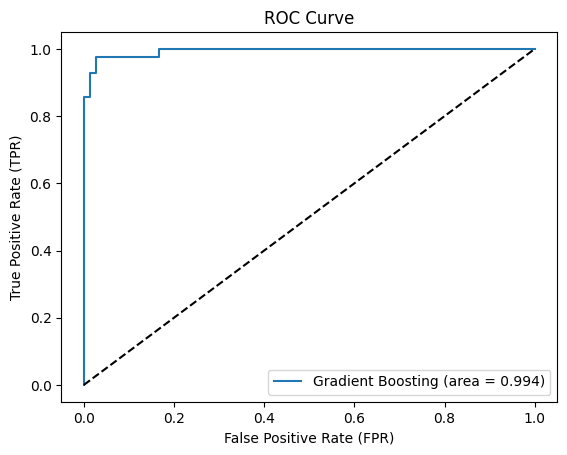

In [92]:
plt.figure()
plt.plot(fpr2, tpr2, label=f'Gradient Boosting (area = {auc_roc_gb:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## conclusion
Accuracy, precision, recall, and f1 score all have very high scores in the high 90s.
- Logisitic Regression scored higher than gradient boosting
- Data was given to us pretty clean, not a lot of preprocessing and hyperparameter tuning had to be done
- That being said, I will run a 2nd experiement with preprocessing and hyperparameter tuning to see if we can get any improvements

# Experiment 2

In this experiment, we will drop the features that have high multicolinearity and low mi predictive power.


## multicolinearity

In [93]:
corr_matrix = X_train.corr().abs()
threshold = 0.8

# returns a list of columns with correlation greater than threshold
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper.columns if any(upper[column] > threshold)]
print("Highly correlated features:", highly_correlated)
print(len(highly_correlated))

Highly correlated features: ['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'fractal_dimension_worst']
16


## mutual info

This test will show how much information each feature shares with the target class (malignant)

In [94]:
mi = mutual_info_classif(X_train, y_train, random_state=rng)
mi_df = pd.DataFrame(index=X.columns, data=mi, columns=['mi_score'])
mi_df.sort_values(by='mi_score', ascending=False)

,mi_score
perimeter_worst,0.485913
area_worst,0.463871
radius_worst,0.444643
concave points_worst,0.436963
concave points_mean,0.436414
perimeter_mean,0.408533
concavity_mean,0.368962
radius_mean,0.362980
area_mean,0.356792
area_se,0.352940


## lr coefficients

In [95]:
lr_coefs = pipe_lr.named_steps['lr'].coef_
pd.Series(data = lr_coefs[0], index = X.columns).sort_values(ascending=False)

radius_se                  1.154456
texture_worst              1.143108
radius_worst               1.000185
concave points_mean        0.959890
concavity_worst            0.950168
symmetry_worst             0.899450
area_worst                 0.867363
perimeter_worst            0.823434
area_se                    0.822185
concavity_mean             0.803326
concave points_worst       0.755066
smoothness_worst           0.739992
perimeter_se               0.718678
fractal_dimension_worst    0.638306
radius_mean                0.472325
area_mean                  0.466059
perimeter_mean             0.449323
texture_mean               0.381906
smoothness_se              0.369468
concave points_se          0.312142
compactness_worst          0.031842
smoothness_mean            0.019184
texture_se                -0.072755
symmetry_mean             -0.173549
fractal_dimension_mean    -0.206950
concavity_se              -0.207044
symmetry_se               -0.219797
compactness_mean          -0

## gb feature importances

In [96]:
pipe_gb.named_steps['gb'].feature_importances_
gb_feature_importances = pd.Series(pipe_gb.named_steps['gb'].feature_importances_.round(6), index=X_test.columns)
gb_feature_importances.sort_values(ascending=False)

perimeter_worst            0.260644
concave points_mean        0.225970
radius_worst               0.168987
area_worst                 0.115968
concave points_worst       0.084888
texture_worst              0.061005
texture_mean               0.018273
concavity_worst            0.012697
smoothness_worst           0.010734
area_se                    0.010613
fractal_dimension_se       0.005177
compactness_se             0.003667
concave points_se          0.003107
fractal_dimension_worst    0.002751
texture_se                 0.002387
symmetry_worst             0.002147
perimeter_se               0.001443
smoothness_se              0.001377
symmetry_mean              0.001234
area_mean                  0.001149
smoothness_mean            0.001083
compactness_worst          0.000954
concavity_se               0.000938
concavity_mean             0.000712
perimeter_mean             0.000588
fractal_dimension_mean     0.000546
radius_mean                0.000405
radius_se                  0

## drop features

In [97]:
print(len(X_train.columns))
print(len(X_test.columns))

30
30


In [98]:
# threshold is set to the mean of the mutual information scores
mi_threshold = mi.mean()
corr_mi_mix = []
# iterate through highly correlated column names
for i in highly_correlated:
    #if the highly correlated column name is in the mutual info df AND is greater than the threshold:
    if i in mi_df.index and mi_df.loc[i, 'mi_score'] > mi_threshold:
        corr_mi_mix.append(i)

corr_mi_mix

        

['perimeter_mean',
 'area_mean',
 'concavity_mean',
 'concave points_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

In [99]:
# dropping highly correlated low mi columns and re assigning to train set
X_train_2 = X_train[corr_mi_mix]

X_test_2 = X_test[corr_mi_mix]
print(len(X_train_2.columns))
print(len(X_test_2.columns))

12
12


## model training

In [100]:
pipe_lr.fit(X_train_2, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(random_state=RandomState(MT19937) at 0x2540DBA3E40))])

In [101]:
pipe_gb.fit(X_train_2, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('gb',
                 GradientBoostingClassifier(random_state=RandomState(MT19937) at 0x2540DBA3E40))])

## predictions

In [102]:
y_pred_lr = pipe_lr.predict(X_test_2)
y_pred_gb = pipe_gb.predict(X_test_2)
print(f'Logistic Regression classification report:\n{classification_report(y_test, y_pred_lr)}')
print(f'Gradient Boosting classification report:\n{classification_report(y_test, y_pred_gb)}')

Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Gradient Boosting classification report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## conclusion

- logistic regression outperformed gradient boosting
- experiment 1 had better results
- experiment 3 will fine tune logistic regression and gradient boosting hyperparameters using gridsearch cv

# Experiment 3

## model  training

In [ ]:
#logisitic regression pipe
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=rng))
])

#gradient boosting pipe
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=rng))
])

#logistic regression params and grid
param_grid_lr = [
    {'lr__penalty': [None, 'l2'],
     'lr__C':[0.001, 0.01, 0.1, 1,]}
]

grid_lr = GridSearchCV(estimator=pipe_lr,
                       param_grid=param_grid_lr,
                       n_jobs=-2)

#gradient boosting params and grid
n_estimators = [50, 100, 200, 300, 400, 500]
learning_rate = np.linspace(0.005, 0.01, num=6).tolist()
max_depth = [3, 4, 5, 6, 7]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 3, 4]
max_features = [None, 'sqrt', 'log2']
param_grid_gb = [
    {
        'gb__n_estimators': n_estimators,
        'gb__learning_rate': learning_rate,
        'gb__max_depth': max_depth,
        'gb__min_samples_split': min_samples_split,
        'gb__min_samples_leaf': min_samples_leaf,
        'gb__max_features': max_features
    }
]
grid_gb = GridSearchCV(estimator=pipe_gb,
                       param_grid=param_grid_gb,
                       n_jobs=-2)

# #model fit: following code is commented out to avoid retraining; model has been dumped to pkl file, and will be loaded in the next cell
# grid_lr.fit(X_train, y_train)
# grid_gb.fit(X_train, y_train)
# dump(grid_lr,'grid_lr.pkl')
# dump(grid_gb, 'grid_gb.pkl')

['grid_gb.pkl']

# ToDos
- [  ] Experiment 3 - fine tune gradient boosting with grid search cv
- [  ] Next up, load the new model file for testing and analyzing results